Installing necessary package

In [5]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 12.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [7]:
!pip install opencv-python

### Import the packages

In [6]:
import ultralytics
print(ultralytics.__version__)

8.2.2


In [37]:
import os
import cv2
import glob
from typing import Dict
import yaml
import random
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO
from PIL import Image
from google.colab import drive
from matplotlib import pyplot as plt

### Get the Dataset From Kaggle
 This Dataset is chosen because:

In [10]:
%%time
drive.mount('/content/drive')

Saving css-data.zip to css-data.zip
CPU times: user 57.5 s, sys: 1min 31s, total: 2min 29s
Wall time: 35min 36s


In [ ]:
!unzip css-data.zip

In [52]:
DATASET_DIR = "/content/css-data"
OUTPUT_DIR = "/content/"
IMAGE_PATH = "/content/css-data/train/images/construction-986-_jpg.rf.3ecb527ce78e89716a17826e5d05f682.jpg"
CLASSES = [
    'Hardhat',
    'Mask',
    'No-Hardhat',
    'No-Mask',
    'No-Safety Vest',
    'Person',
    'Safety Cone',
    'Safety Vest',
    'machinery',
    'vehicle'
]
NUM_CLASSES = len(CLASSES)
EPOCHS = 50
BATCH_SIZE = 16
OPTIMIZER = 'auto'
LEARNING_RATE = 1e-3
LR_FACTOR = 0.01
WEIGHT_DECAY = 5e-4
FRACTION = 1.0
PATIENCE = 20
SEED = 88
PROFILE = False
BASE_MODEL = 'yolov8n'
MODEL_WEIGHT = f"{BASE_MODEL}.pt"
EXP_NAME = f"ppe_css_{BASE_MODEL}_epochs"


### Create YAML File and Read it

In [13]:
# Create yaml file
dict_file = {
    'train': os.path.join(DATASET_DIR, 'train'),
    'val': os.path.join(DATASET_DIR, 'valid'),
    'test': os.path.join(DATASET_DIR, 'test'),
    'nc': NUM_CLASSES,
    'names': CLASSES
}

with open(os.path.join(OUTPUT_DIR, 'data.yaml'), 'w+') as file:
  yaml.dump(dict_file, file)

In [14]:
# Read yaml file
def read_yaml(file_path: Path) -> Dict:
  with open(file_path, 'rb') as file:
    try:
      data = yaml.safe_load(file)
      return data
    except yaml.YAMLError as e:
      print(f"Yaml File Error: {e}")
      return None

file_path = os.path.join(OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml(file_path)
if yaml_data:
  formatted_yaml = yaml.dump(yaml_data, default_style=False)
  print(formatted_yaml)

names:
- Hardhat
- Mask
- No-Hardhat
- No-Mask
- No-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: /content/css-data/test
train: /content/css-data/train
val: /content/css-data/valid



### Exploratory Data Analysis

In [40]:
def show_image(image_path: Path = None, folder_path: Path = None, random_img: bool = True, num_imgs: int = 2) -> None:
  if random_img:
    pass
    image_files = [i for i in os.listdir(folder_path) if i.endswith(('jpg', 'png', 'jpeg', 'gif'))]
    if len(image_files) < num_imgs:
      raise ValueError("Images is not enough. Try another folder path")
    selected_imgs = random.sample(image_files, num_imgs)

    num_cols = 5
    num_rows = (num_imgs + num_cols -1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    for i, file_name in enumerate(selected_imgs):
      img = Image.open(os.path.join(folder_path, file_name))
      if num_rows == 1:
        ax = axes[i % num_cols]
      else:
        ax = axes[i // num_cols, i % num_cols]
      ax.imshow(img)
      ax.axis('off')
    for i in range(num_imgs, num_rows * num_cols):
      if num_rows == 1:
        fig.delaxes(axes[i % num_cols])
      else:
        fig.delaxes(axes[i // num_cols, i % num_cols])
    plt.tight_layout()
    plt.show()

  else:
    if isinstance(image_path, str):
      img = Image.open(image_path)
      plt.imshow(img)
    elif isinstance(image_path, np.ndarray):
      image = image_path[..., ::-1]
      img = Image.fromarray(image)
      plt.imshow(img)
    else:
      raise ValueError("Unsupported image format")
    print(f"Type: {type(img)} \n")
    print(f"Shape: {np.array(img).shape}")
    plt.show()

Type: <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape: (640, 640, 3)


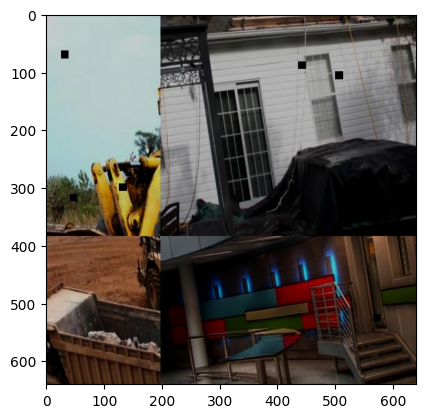

In [44]:
show_image(image_path=IMAGE_PATH, random_img=False)

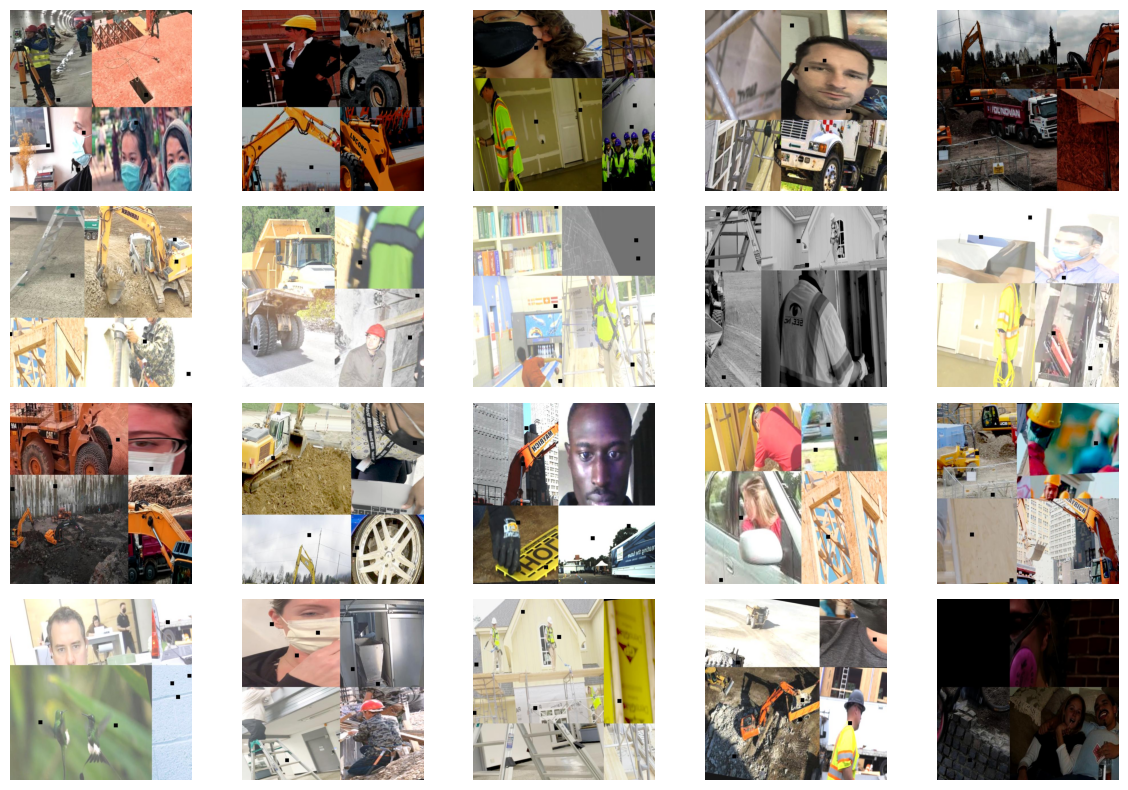

In [17]:
folder_path = DATASET_DIR + '/train/images/'
show_image(folder_path=folder_path, num_imgs=20)

#### Get Image Properties

In [18]:
def image_properties(image_path: Path) -> Dict:
  properties = {}
  img = cv2.imread(image_path)
  if img is None:
    raise ValueError("Image is not exist")
  properties = {
      "width": img.shape[1],
      "height": img.shape[0],
      "channels": img.shape[2] if len(img.shape) == 3 else 1,
      "dtype": img.dtype
  }
  return properties

In [19]:
img_properties = image_properties(IMAGE_PATH)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

#### Image Statistic

In [20]:
%%time
class_idx = {str(i): CLASSES[i] for i in range(NUM_CLASSES)}
class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
  class_count = {CLASSES[i]: 0 for i in range(NUM_CLASSES)}
  path = os.path.join(DATASET_DIR, mode, 'labels')
  for file in os.listdir(path):
    with open(os.path.join(path, file)) as f:
      lines = f.readlines()
      for cls in set([line[0] for line in lines]):
        class_count[class_idx[cls]] += 1
  data_len[mode] = len(os.listdir(path))
  class_stat[mode] = class_count
  class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})
  dataset_stats = pd.DataFrame(class_info)
  dataset_stats

CPU times: user 68.3 ms, sys: 45.6 ms, total: 114 ms
Wall time: 127 ms


In [23]:
dataset_stats

,Mode,Hardhat,Mask,No-Hardhat,No-Mask,No-Safety Vest,Person,Safety Cone,Safety Vest,machinery,vehicle,Data_Volume
0,train,1314,1096,1380,1531,1864,2526,631,1319,2101,744,2605
1,valid,42,19,37,44,56,84,13,28,26,16,114
2,test,30,16,25,30,36,59,8,22,22,15,82


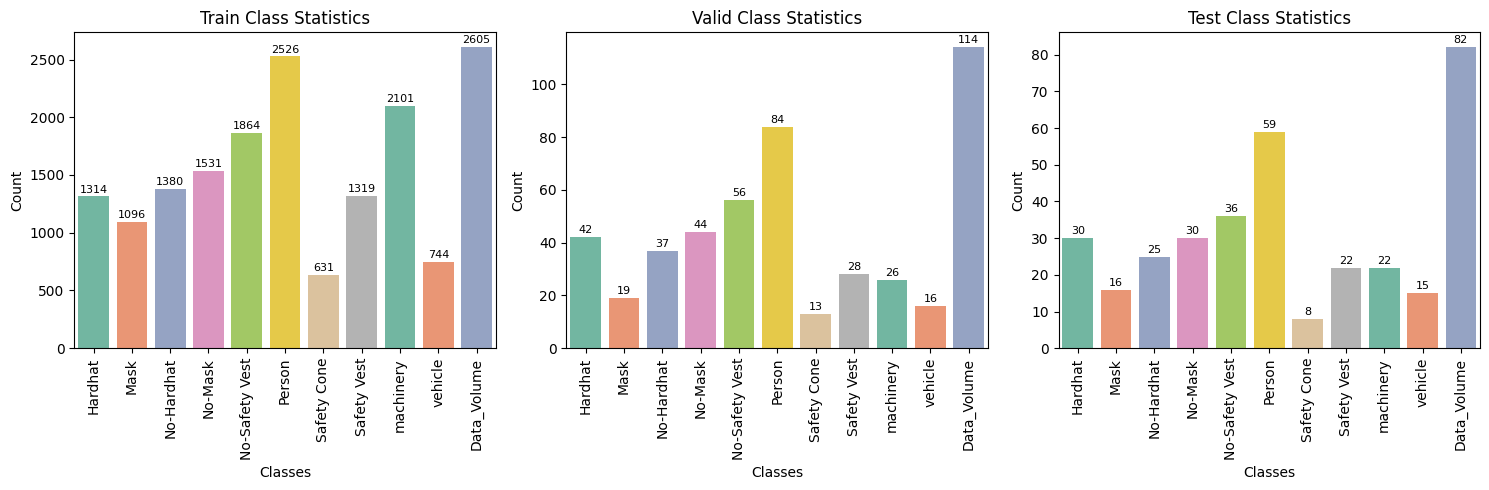

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, mode in enumerate(['train', 'valid', 'test']):
  sns.barplot(
      data=dataset_stats[dataset_stats['Mode'] == mode].drop(columns='Mode'),
      orient='v',
      ax=axes[i],
      palette='Set2'
  )
  axes[i].set_title(f"{mode.capitalize()} Class Statistics")
  axes[i].set_xlabel('Classes')
  axes[i].set_ylabel('Count')
  axes[i].tick_params(axis='x', rotation=90)

  for p in axes[i].patches:
    axes[i].annotate(f"{int(p.get_height())}",
                     (p.get_x() + p.get_width() / 2, p.get_height()),
                     ha='center',
                     va='center',
                     fontsize=8,
                     color='black',
                     xytext=(0, 5),
                     textcoords='offset points')
plt.tight_layout()
plt.show()

In [26]:
%%time
for mode in ['train', 'valid', 'test']:
  print(f"Image size in {mode} set: ")
  img_size = 0
  for file in glob.glob(os.path.join(DATASET_DIR, mode, 'images', '*')):
    image = Image.open(file)
    if image.size != img_size:
      print(image.size)
      img_size = image.size

Image size in train set: 
(640, 640)
Image size in valid set: 
(640, 640)
Image size in test set: 
(640, 640)
CPU times: user 192 ms, sys: 55.7 ms, total: 248 ms
Wall time: 248 ms


In [46]:
MODEL = YOLO(MODEL_WEIGHT)
results = MODEL.predict(
    source = IMAGE_PATH,
    classes = [0],
    conf = 0.30,
    imgsz = (img_properties['height'], img_properties['width']),
    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)


image 1/1 /content/css-data/train/images/construction-986-_jpg.rf.3ecb527ce78e89716a17826e5d05f682.jpg: 640x640 (no detections), 329.3ms
Speed: 8.1ms preprocess, 329.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
0 label saved to runs/detect/predict/labels


Type: <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape: (640, 640, 3)


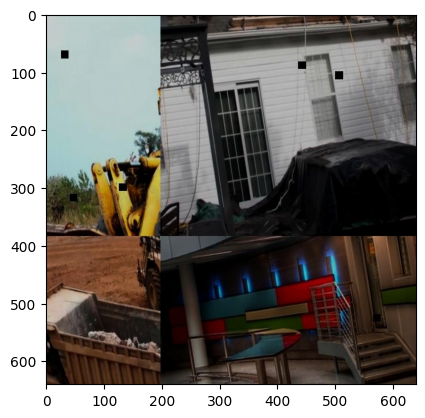

In [47]:
example_image = IMAGE_PATH.split('/')[-1]
show_image(image_path=f"/content/runs/detect/predict/{example_image}", random_img=False)

In [ ]:
MODEL = YOLO(MODEL_WEIGHT)
MODEL.train(
    data=os.path.join(OUTPUT_DIR, 'data.yaml'),
    task='detect',
    imgsz=(img_properties['height'], img_properties['width']),
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    optimizer=OPTIMIZER,
    lr0=LEARNING_RATE,
    lrf=LR_FACTOR,
    weight_decay=WEIGHT_DECAY,
    fraction=FRACTION,
    patience=PATIENCE,
    profile=PROFILE,
    name=f"{BASE_MODEL}_{EXP_NAME}",
    seed=SEED,
    val=True,
    amp=True,
    exist_ok=True,
    resume=False,
    verbose=False
)

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data.yaml, epochs=50, time=None, patience=20, batch=16, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_ppe_css_yolov8n_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, s

100%|██████████| 755k/755k [00:00<00:00, 80.8MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/css-data/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:01<00:00, 1669.06it/s]

train: WARNING ⚠️ /content/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


train: New cache created: /content/css-data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/css-data/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 2045.35it/s]

val: New cache created: /content/css-data/valid/labels.cache
Plotting labels to runs/detect/yolov8n_ppe_css_yolov8n_epochs/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/yolov8n_ppe_css_yolov8n_epochs
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.396      2.835      1.503        211        640: 100%|██████████| 163/163 [36:11<00:00, 13.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:38<00:00,  9.73s/it]

                   all        114        697      0.384      0.349      0.329      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.305       1.86      1.444        229        640: 100%|██████████| 163/163 [36:30<00:00, 13.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:37<00:00,  9.40s/it]

                   all        114        697      0.601      0.419      0.459      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.258      1.686      1.425        384        640:   9%|▊         | 14/163 [03:04<33:01, 13.30s/it]